<a href="https://colab.research.google.com/github/hsiehbocheng/TextClassification_implement/blob/main/TextClassification_Implement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NLP Text Categorization implement with Python**


- *自然語言處理(NLP) 是人工智慧和語言學領域的分支學科。此領域探討如何處理及運用自然語言; 自然語言處理包括多方面和步驟，基本有認知、理解、生成等部分 - 維基百科*

- 自然語言處理包含：語意分析(Semantic Analysis)、命名實體(NER)、文本分類(Text Categorization)、翻譯(Translaton) …… 等任務，
這裡我基於 【人工智慧應用專題】人工智慧主流技術 課程，劉瓊如老師在第一次與第四次上課所介紹的語言模型(詞向量表示法)，利用 python 實作，因為是簡單實現老師上課所教的詞向量方法，所以會著重在如何快速利用現有 python 套件完成任務，模型背後原理因為篇幅在這就先不深入解釋。

- 步驟為： 1. 資料清理 2. 應用詞向量模型 3. XGBoost 4. LSTM

- 另外，初學ML和NLP，主要根據老師上課、炎龍老師 YT 頻道還有網路上東看看西看看自學而來，如果有錯誤還請多多包容多多指教 🫡。
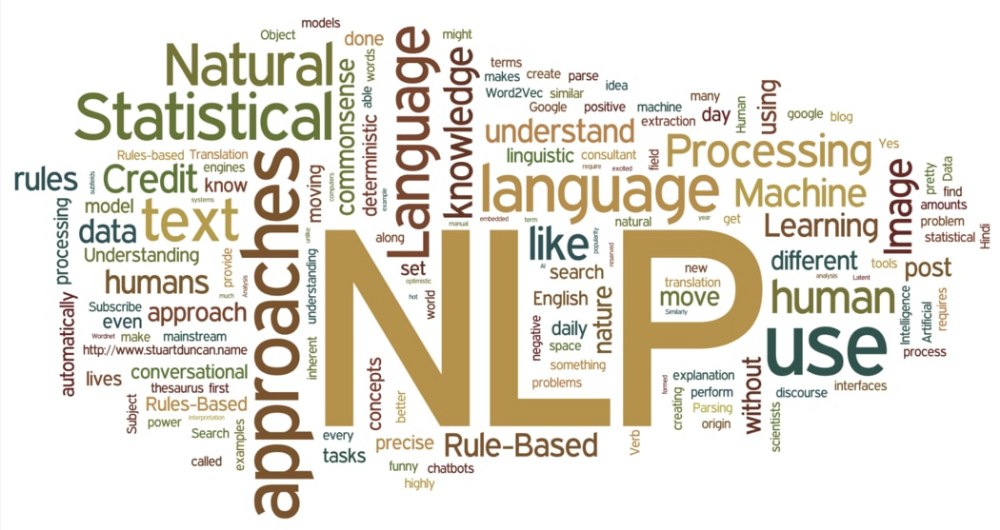

- **文本分類任務的流程大致上來說如下：**

1. **資料(文本)清理**
2. **量化文章**
3. **分類模型**

- **資料是電影評論，包含用戶資訊、電影、評論、星星數、Like 數，這邊我只留我想要的欄位，Comment(評論)、Star(星星數)，並且設定 Star > 3 是正面評論，否則為負面評論，也就是在做二元分類的任務，只預測該評論為正面or負面，另外，因為資料量有兩百多萬筆，所以我只抽取1/4，一部分的資料做實做。**



In [ ]:
import os
import pandas as pd
import numpy as np
import re
import jieba
import jieba.analyse
import matplotlib.pyplot as plt
import pickle

load data


In [ ]:
with open('dmsc_clean.pickle', 'rb') as f:
  dmsc = pickle.load(f)

In [ ]:
dmsc = pd.read_csv('DMSC.csv')


- **資料清理**

  - 資料清理包含斷詞、停用詞刪除，用到套件有：re、jieba、nltk 等等。
先把資料讀進來觀察一下，

In [ ]:
dmsc.head()

,ID,Movie_Name_EN,Movie_Name_CN,Crawl_Date,Number,Username,Date,Star,Comment,Like
0,0,Avengers Age of Ultron,复仇者联盟2,2017-01-22,1,然潘,2015-05-13,3,连奥创都知道整容要去韩国。,2404
1,1,Avengers Age of Ultron,复仇者联盟2,2017-01-22,2,更深的白色,2015-04-24,2,非常失望，剧本完全敷衍了事，主线剧情没突破大家可以理解，可所有的人物都缺乏动机，正邪之间、...,1231
2,2,Avengers Age of Ultron,复仇者联盟2,2017-01-22,3,有意识的贱民,2015-04-26,2,2015年度最失望作品。以为面面俱到，实则画蛇添足；以为主题深刻，实则老调重弹；以为推陈出...,1052
3,3,Avengers Age of Ultron,复仇者联盟2,2017-01-22,4,不老的李大爷耶,2015-04-23,4,《铁人2》中勾引钢铁侠，《妇联1》中勾引鹰眼，《美队2》中勾引美国队长，在《妇联2》中终于...,1045
4,4,Avengers Age of Ultron,复仇者联盟2,2017-01-22,5,ZephyrO,2015-04-22,2,虽然从头打到尾，但是真的很无聊啊。,723


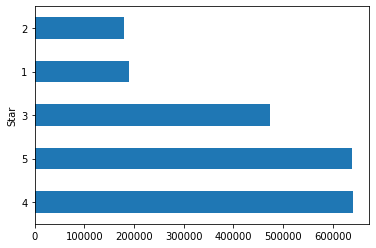

In [ ]:
dmsc.value_counts('Star').plot(kind='barh')

In [ ]:
dmsc = dmsc[['Star', 'Comment']]
dmsc['label'] = [1 if star > 3 else 0 for star in dmsc.Star] # 0 for negative, 1 for positive
dmsc.drop(columns='Star', inplace=True)
dmsc = dmsc.sample(frac=1 / 4, random_state=123)
dmsc.reset_index(drop=True, inplace=True)

In [ ]:
dmsc.value_counts('label')

label
1    303293
0    200229
dtype: int64

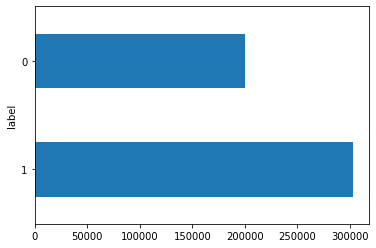

In [ ]:
dmsc.value_counts('label').plot(kind='barh')

- **有 303,293 筆正面評論，200,229 筆負面評論。**

In [ ]:
dmsc.shape
display(dmsc.head())

,Comment,label
0,讲故事讲的清楚明白，除了水下的场景有点唯美，其余的挺平淡直白的，喜欢,1
1,友情的代表之作,1
2,平衡一星,1
3,终于还是去电影院把这部电影看完了，反映的东西和问题都挺深刻的，略沉重。做冰棍那段，树懒那段...,1
4,我觉得没啥好看的啊 一个失败者的yy.........有点好笑但是不是我喜欢的类型...,0


###**data preprocessing**

- **可以發現資料為簡體，隨然聽說 Jieba 套件對於簡體字的斷詞效果比較好，但我這邊還是透過 opencc 這個套件將文字轉換為繁體。**

In [ ]:
!pip install opencc
from opencc import OpenCC
cc = OpenCC('s2t') # 簡體字轉繁體字

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 769 kB 18.0 MB/s 


In [ ]:
dmsc['Comment'] = dmsc['Comment'].apply(cc.convert)

In [ ]:
dmsc.head()

,Comment,label
0,講故事講的清楚明白，除了水下的場景有點唯美，其餘的挺平淡直白的，喜歡,1
1,友情的代表之作,1
2,平衡一星,1
3,終於還是去電影院把這部電影看完了，反映的東西和問題都挺深刻的，略沉重。做冰棍那段，樹懶那段...,1
4,我覺得沒啥好看的啊 一個失敗者的yy.........有點好笑但是不是我喜歡的類型...,0


- **斷詞與刪除停用詞**

  - **從 nltk 下載停用詞，利用 jieba 斷詞，停用詞例如：的、一時、一下……等辭彙，斷詞利用 jieba 的 lcut 斷詞，並暫時用空格斷開。**

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopWords = stopwords.words('chinese')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
stopWords[:10]

['一', '一下', '一些', '一切', '一则', '一天', '一定', '一方面', '一旦', '一时']

In [ ]:
stopWords = [cc.convert(word) for word in stopWords]
print(stopWords[:10])

['一', '一下', '一些', '一切', '一則', '一天', '一定', '一方面', '一旦', '一時']


In [ ]:
urlFilter = re.compile(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%|\-|_|:| \.\.\. )*\b')

def CutContent(comment, stopWords=stopWords):
  parsed = jieba.lcut(comment)
  parsed2 = list(filter(lambda text: text not in stopWords and len(text) > 1, parsed))
  parsed2 = ' '.join(parsed2)

  return parsed2

In [ ]:
dmsc.iloc[:10, :]['Comment'].apply(CutContent)

0                           故事 講的 明白 水下 場景 唯美 平淡 直白 喜歡
1                                             友情 代表 之作
2                                                平衡 一星
3    終於還 去電 影院 這部 電影 東西 深刻 沉重 冰棍 那段 樹懶 那段 哈哈哈 樹懶 好像...
4               我覺 好看 一個 失敗者 yy ......... 好笑 喜歡 類型 ...
5                                                   真心
6                        中學 時代 冒險 幻覺 特效 不錯 一個 電影 工業 能力
7    週還 週看 想起 打個 週六 晚上 大學 城的電 影院 上座率 滿場 包括 小夥伴 完後都 ...
8                                                   嚇死
9                       劇情 想表達 東西 西方 不算 新鮮 天朝 電影 一記 耳光
Name: Comment, dtype: object

In [ ]:
CutContent(dmsc['Comment'][99])

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.838 seconds.
DEBUG:jieba:Loading model cost 0.838 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


'感覺 鋼鐵俠 準備 原型 妮妮'

- **這邊我直接定義一個 function ，``clean_Comment``，基本處理有刪除超連結(data 裡面應該是沒有超連結，但實務上常會遇到且需要處理)、英文改成小寫、刪除 NA 等等。**

In [ ]:
def clean_Comment(data: pd.DataFrame, comment_col_name='Comment', urlFilter=urlFilter, stopWords=stopWords):
  data['parsed_Comment'] = data['Comment']
  data['parsed_Comment'] = data['parsed_Comment'].str.lower()
  data['parsed_Comment'] = data['parsed_Comment'].str.replace(urlFilter, '')
  data['parsed_Comment'] = data['parsed_Comment'].str.replace(r'\n|\.|\u3000| ', '')
  data['parsed_Comment'] = data['parsed_Comment'].str.replace(r"\d+\.?\d*", "")

  data = data.dropna(axis=0, subset=['parsed_Comment']).reset_index(drop=True)
  parsed_Comment = data['parsed_Comment'].apply(CutContent)
  data['parsed_Comment'] = parsed_Comment
  data.drop_duplicates(inplace=True)
  data.reset_index(drop=True, inplace=True)

  return data

In [ ]:
dmsc = clean_Comment(dmsc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
dmsc.head()

,Comment,label,parsed_Comment
0,講故事講的清楚明白，除了水下的場景有點唯美，其餘的挺平淡直白的，喜歡,1,故事 講的 明白 水下 場景 唯美 平淡 直白 喜歡
1,友情的代表之作,1,友情 代表 之作
2,平衡一星,1,平衡 一星
3,終於還是去電影院把這部電影看完了，反映的東西和問題都挺深刻的，略沉重。做冰棍那段，樹懶那段...,1,終於還 去電 影院 這部 電影 東西 深刻 沉重 冰棍 那段 樹懶 那段 哈哈哈 樹懶 好像...
4,我覺得沒啥好看的啊 一個失敗者的yy.........有點好笑但是不是我喜歡的類型...,0,我覺 好看 一個 失敗者 yy 好笑 喜歡 類型


In [ ]:
with open('dmsc_clean.pickle', 'wb') as f:
  pickle.dump(dmsc, f)

In [ ]:
dmsc = clean_Comment(dmsc)
with open('dmsc_all_clean.pickle', 'wb') as f:
  pickle.dump(dmsc, f)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
positive_comments = dmsc.query('label==1')['parsed_Comment']
negative_comments = dmsc.query('label==0')['parsed_Comment']
comments = dmsc['parsed_Comment']

In [ ]:
comments[1]

'友情 代表 之作'

In [ ]:
str(comments[1]).split(' ')

['友情', '代表', '之作']

- **這樣最基本的文字清理完成了，可以稍微利用各字頻率看一下正反面最常出現的字有什麼，collections 的 Counter 可以替我們算出字頻**

In [ ]:
from collections import Counter
tokens_all = []
tokens_positive = []
tokens_negative = []

for comment in comments:
  tokens = str(comment).split(' ') 
  tokens_all += tokens
for comment in positive_comments:
  tokens = str(comment).split(' ') 
  tokens_positive += tokens
for comment in negative_comments:
  tokens = str(comment).split(' ') 
  tokens_negative += tokens

In [ ]:
len(set(tokens_all))

272797

In [ ]:
for ind, (key, val) in enumerate(Counter(tokens_all).items()):
  if ind < 10:
    print(key, val)
  else:
    break

故事 63012
講的 1768
明白 6694
水下 68
場景 9040
唯美 3080
平淡 2494
直白 608
喜歡 58890
友情 4300


In [ ]:
key_words_all = pd.DataFrame(sorted(Counter(tokens_all).items(), key=lambda x:x[1], reverse=True)).iloc[:50, ]
key_words_pos = pd.DataFrame(sorted(Counter(tokens_positive).items(), key=lambda x:x[1], reverse=True)).iloc[:50, ]
key_words_neg = pd.DataFrame(sorted(Counter(tokens_negative).items(), key=lambda x:x[1], reverse=True)).iloc[:50, ]

pdWordFreq = pd.concat([key_words_all, key_words_pos, key_words_neg], axis=1)
pdWordFreq.columns = ['全部評論關鍵字', 'Freq', '正面評論關鍵字', 'Freq', '負面評論關鍵字', 'Freq']

del key_words_all, key_words_pos, key_words_neg, tokens_all, tokens_positive, tokens_negative

這裡可以發現正反兩面常出現的詞其實很難看得出差別，除了反面有一個尷尬以外，這裡可能是因為用 3 顆星去二分不夠嚴謹。

In [ ]:
display(pdWordFreq.head(50))

,全部評論關鍵字,Freq,正面評論關鍵字,Freq,負面評論關鍵字,Freq
0,電影,82261,電影,52088,電影,30173
1,劇情,45507,劇情,24049,劇情,21458
2,真的,32710,好看,23740,故事,13138
3,好看,32407,喜歡,21778,真的,12675
4,故事,31506,不錯,20709,特效,12474
5,一個,31151,真的,20035,一個,11820
6,不錯,29545,一個,19331,感覺,11719
7,喜歡,29445,故事,18368,不錯,8836
8,感覺,27403,一部,16094,好看,8667
9,特效,26002,感覺,15684,演技,8427


### **文章量化**

- **用字詞向量表示文章，每一個字詞會向量中的一個維度，向量中每個數值可以代表該字詞再向量中的重要程度。**

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train, test = train_test_split(dmsc, test_size=0.3, random_state=321)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
print('--train--')
print(train['label'].value_counts())
print('\n--test--')
print(test['label'].value_counts())

--train--
1    212443
0    140022
Name: label, dtype: int64

--test--
1    90850
0    60207
Name: label, dtype: int64


In [ ]:
y_train = train['label']
comment_train = train['parsed_Comment']

y_test = test['label']
comment_test = test['parsed_Comment']

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

## **tfidf**


- **字詞的重要性可以從在文本中的頻率 (TF) 判斷，但是出現太多次並不見得是最重要的字，例如：你們、這個、a、the，都是很常出現的詞，但其實並不重要，所以引入反向文件頻率 IDF。**


- **python 的 gensim、sklearn 都有相關的指令可以幫助我們算語料庫的 tfidf
這裡我使用 sklearn 的 TfidfVerctorizer。**


- **該指令有很多相關的參數可以設定，例如 ngram、norm，這邊不細講，可以參考 sklearn 文件，而我設定 max_features = 1000，代表我只要 1000 維度的詞向量。可以像剛才看詞頻的方法，利用 tfidf 看出在正反面的關鍵字。**

In [ ]:
ngram_range=(1, 2)
max_feature = 1000
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        max_features=max_feature,
                        norm='l2',)

In [ ]:
features_train_tfdif = tfidf.fit_transform(comment_train)
features_test_tfidf = tfidf.transform(comment_test)

In [ ]:
features_train_tfdif.shape

(352465, 1000)

In [ ]:
tfdif_score_all = pd.DataFrame({'全部評論': tfidf.get_feature_names(),
                   'tfidf_score': features_train_tfdif.toarray().mean(axis=0).tolist()}).sort_values(by='tfidf_score', ascending=False).reset_index(drop=True)
tfdif_score_pos = pd.DataFrame({'正面評論': tfidf.get_feature_names(),
                   'tfidf_score': features_train_tfdif.toarray()[y_train==1].mean(axis=0).tolist()}).sort_values(by='tfidf_score', ascending=False).reset_index(drop=True)
tfdif_score_neg = pd.DataFrame({'負面評論': tfidf.get_feature_names(),
                   'tfidf_score': features_train_tfdif.toarray()[y_train==0].mean(axis=0).tolist()}).sort_values(by='tfidf_score', ascending=False).reset_index(drop=True)
pdWordTfidf = pd.concat([tfdif_score_all, tfdif_score_pos, tfdif_score_neg], axis=1)
del tfdif_score_all, tfdif_score_pos, tfdif_score_neg

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
pdWordTfidf.head(20)

,全部評論,tfidf_score,正面評論,tfidf_score,負面評論,tfidf_score
0,電影,0.033508,電影,0.034212,電影,0.032440
1,好看,0.023383,好看,0.028047,劇情,0.028424
2,劇情,0.022350,喜歡,0.022659,特效,0.019289
3,喜歡,0.018351,不錯,0.021157,真的,0.018317
4,不錯,0.017822,劇情,0.018346,故事,0.017385
5,真的,0.017750,真的,0.017375,感覺,0.017192
6,故事,0.015794,一個,0.015991,好看,0.016306
7,一個,0.015730,故事,0.014745,一個,0.015333
8,感覺,0.015217,感覺,0.013915,不錯,0.012761
9,特效,0.015190,一部,0.013729,演技,0.012560


## **word2vec**

- **這裡用 gensim Word2Vec，在訓練詞向量的時候通常會使用大量語料庫，讓模型學習，例如百度、維基百科資料，而這邊我就只利用 train data 去訓練詞向量，另外， Word2Vec 訓練前需要先建立字典，以及設定一些超參數，常見的有詞向量維度 size、min_count、window、sg(CBOW or skip Gram)**


In [ ]:
from gensim.models import word2vec
import logging
import multiprocessing
import random
logging.basicConfig(format = '%(asctime)s: %(levelname)s: %(message)s')
logging.root.setLevel(level=logging.INFO)

In [ ]:
# comment lists to list of lists with tokens
comment_train_list_of_list = [i.split(' ') for i in comment_train]
comment_test_list_of_list = [i.split(' ') for i in comment_test]

In [ ]:
# load preTrained model
w2v = word2vec.Word2Vec.load('preTrainModel/w2v')

In [ ]:
w2v = word2vec.Word2Vec(size=128, min_count=5, window=5, sg=1)
w2v.build_vocab(comment_train_list_of_list)

In [ ]:
# training
for i in range(20):
  random.shuffle(comment_train_list_of_list)
  w2v.train(comment_train_list_of_list, total_examples=len(comment_train_list_of_list), epochs=1)

- **訓練好模型後可以用一些指令去看單詞的向量(word2vec)、與單詞最接近的 topn 個字**

In [ ]:
w2v.save('preTrainModel/w2v')

INFO:gensim.utils:saving Word2Vec object under preTrainModel/w2v, separately None
INFO:gensim.utils:not storing attribute vectors_norm
INFO:gensim.utils:not storing attribute cum_table
INFO:gensim.utils:saved preTrainModel/w2v


In [ ]:
# get vectors
w2v.wv['好看']

array([-0.07624044,  0.54996717,  0.07931037,  0.17926815,  0.17492263,
        0.2499152 , -0.08290193,  0.10925725,  0.10681236, -0.15923995,
        0.03827087, -0.35679287,  0.2101079 , -0.01023435, -0.15941802,
        0.17183442,  0.25985724, -0.0475928 , -0.15847418, -0.21847853,
       -0.25462207, -0.01732479, -0.29056114, -0.3411396 ,  0.29943117,
        0.04533172,  0.12884842, -0.21876003, -0.18335484,  0.09325098,
       -0.01296946, -0.18653597,  0.13476275,  0.37859872, -0.28993973,
        0.20818067, -0.2802475 , -0.03020364, -0.02480829, -0.06626986,
       -0.3239181 , -0.12698999, -0.22957925,  0.10426855,  0.25366724,
       -0.45320144, -0.11683183, -0.17463548,  0.01916694,  0.271838  ,
        0.22925057, -0.12237339,  0.06364377,  0.5414609 ,  0.08834707,
        0.13316193,  0.04900701,  0.10003951, -0.02608932,  0.07416094,
        0.00329822, -0.4114951 ,  0.35852277, -0.18703201,  0.08409061,
        0.20408279, -0.46717003,  0.15688786, -0.11199897, -0.01

In [ ]:
# get similar words
w2v.wv.most_similar('好看')

[('沒一', 0.6349935531616211),
 ('精彩', 0.6334841251373291),
 ('超超超', 0.6275707483291626),
 ('沒辣麼', 0.6225746273994446),
 ('電影超', 0.62059485912323),
 ('之後比', 0.6200451254844666),
 ('好笑', 0.595417857170105),
 ('隊差', 0.5940516591072083),
 ('好好看', 0.5938977003097534),
 ('中辣麼', 0.5913739800453186)]

In [ ]:
def most_similar_w2v(words, topn=10):
  similar_df = pd.DataFrame()
  for word in words:
    try:
      similar_words = pd.DataFrame(w2v.wv.most_similar(word, topn=topn), columns=[word, 'cos similarity'])
      similar_df = pd.concat([similar_df, similar_words], axis=1)
    except:
      print(word, 'not found in Word2Vec model')
  return similar_df

In [ ]:
most_similar_w2v(words=['好看', 'marvel', '超英', '英雄', '感人', '動畫', 'XD'])

XD not found in Word2Vec model


,好看,cos similarity,marvel,cos similarity,超英,cos similarity,英雄,cos similarity,感人,cos similarity,動畫,cos similarity
0,沒一,0.634994,漫威,0.782349,兩方,0.614458,超級,0.707471,催淚,0.635825,動畫片,0.777072
1,精彩,0.633484,蝙大戰,0.649243,漫改,0.579943,英雄人物,0.682841,感動,0.633099,動漫,0.720081
2,超超超,0.627571,dc,0.635190,漫威,0.579387,美國個,0.626508,配樂場,0.588288,動畫長,0.651455
3,沒辣麼,0.622575,mcu,0.627376,飛機場,0.570768,主義,0.604675,溫馨,0.571283,美國動漫,0.631582
4,電影超,0.620595,正義聯盟,0.622568,小蟲,0.560575,嘉年華,0.592121,動人,0.568455,皮克斯,0.625188
5,之後比,0.620045,batman,0.616234,制約,0.560453,hero,0.588968,最開,0.566433,walle,0.623528
6,好笑,0.595418,完漫威,0.615926,zemo,0.555412,teamwork,0.576043,最後父親,0.563937,中國近,0.622418
7,隊差,0.594052,downey,0.611506,俠終,0.553900,superhero,0.564316,電話給,0.563054,來動畫,0.616125
8,好好看,0.593898,從美隊,0.609252,趕美,0.552529,主義片,0.564129,太純情,0.559153,迪斯尼,0.610821
9,中辣麼,0.591374,wanda,0.608020,我鐵,0.546476,蓋世,0.562846,淚點,0.553434,歐美動畫,0.610027


- **這邊我們要將新文章轉成詞向量，剛接觸的人可能會疑惑，我不是只有詞向量，又沒有句向量，啊我的資料是句子，我該怎麼辦？
這裡有很多方法，例如直接把句子每個詞向量相加取平均、加權平均（ex: tfidf 加權)，或是 Doc2Vec。這邊我簡單利用平均代表句子向量，在這之前需要先把你的文章中，Word2Vec 模型沒看過的字刪掉，不然模型不知道該怎麼轉成向量，之後就可以把它套入你的 ML 模型啦!**

In [ ]:
comment_test_list_of_list_filtered = [[word for word in com if  word in w2v.wv] for com in comment_test_list_of_list]
comment_train_list_of_list_filtered = [[word for word in com if  word in w2v.wv] for com in comment_train_list_of_list]

In [ ]:
features_train_w2v  = []
features_test_w2v = []

for com in comment_train_list_of_list_filtered:
  if len(com) == 0:
    features_train_w2v.append(np.array([0] * 128))
  else:
    features_train_w2v.append(np.mean([w2v.wv[w] for w in com], axis=0))

for com in comment_test_list_of_list_filtered:
  if len(com) == 0:
    features_test_w2v.append(np.array([0] * 128))
  else:
    features_test_w2v.append(np.mean([w2v.wv[w] for w in com], axis=0))

In [ ]:
features_test_w2v = np.stack(features_test_w2v)
features_train_w2v = np.stack(features_train_w2v)

## **doc2vec**

- **一樣是 gensim 包有提供的，使用方法也和 Word2Vec 差不多。，doc2vec 和word2vec 差距不大，在訓練詞向量模型前，把每個句子給了一個標籤以供後續使用，所以訓練之前一樣要建立詞典，同時要標記句子，這邊利用 LabelsSentence 給每個文章貼上 ‘Tag’。**

In [ ]:
from gensim.models import Doc2Vec, doc2vec

In [ ]:
d2v = Doc2Vec(size=128,
              min_count=5,
              window=5)
comment_tag_list = []
for ind, com in enumerate(comment_train_list_of_list):
  comment_tag_list.append(doc2vec.LabeledSentence(words=com, tags=[str(ind)]))

/usr/local/lib/python3.7/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  


In [ ]:
comment_tag_list[:2]

[LabeledSentence(words=['晚上', '陪欣姐', '中老年', '愛情劇', '女兒', '單身', '爸爸', '喜歡', '一個', '開心', '人開', '開心', '愛呢', '努力', '開心', '開心', '大概', '劉鶯鶯', '喜歡', '放肆'], tags=['0']),
 LabeledSentence(words=['畢竟', '原著', '震撼', '至少', '一部', '打哈欠', '看不下去', '片子'], tags=['1'])]

In [ ]:
d2v.build_vocab(comment_tag_list)

In [ ]:
epoch = 20
for i in range(epoch):
  print(f'epoch: {i+1}/{epoch}')
  random.shuffle(comment_tag_list)
  d2v.train(comment_tag_list, total_examples=len(comment_tag_list), epochs=1)
d2v.save('preTrainModel/d2v')

- **接著一樣可以用 most_similar、most_similar 看最有關係的詞、句子。**

In [ ]:
d2v.most_similar('好看', topn=10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
INFO:gensim.models.keyedvectors:precomputing L2-norms of word weight vectors


[('精彩', 0.6138744354248047),
 ('喜歡', 0.575271487236023),
 ('不錯', 0.5678427219390869),
 ('有意思', 0.5677773356437683),
 ('感人', 0.5598394870758057),
 ('很不錯', 0.5501113533973694),
 ('還不錯', 0.539584755897522),
 ('挺不錯', 0.5301656723022461),
 ('實話', 0.5283814668655396),
 ('很棒', 0.5279253721237183)]

In [ ]:
x = '好看很帥緊湊，超喜歡的，不懂為何有人分數給那麼低,真的不錯阿'
x = CutContent(x).split(' ')
print(x)

['好看', '很帥', '超喜歡', '為何', '有人', '分數給', '那麼', '真的', '不錯']


In [ ]:
test_d2v = d2v.infer_vector(x, alpha=0.025, steps=300)
sims = d2v.docvecs.most_similar([test_d2v], topn=10)

for count, sim in sims:
  print([sen for sen in comment_tag_list if sen.tags==[str(count)]])
  print(sim)

[LabeledSentence(words=['真心', '有人', '值星'], tags=['53715'])]
0.6500393152236938
[LabeledSentence(words=['有人', '真心', '還不錯', '記住', '記住'], tags=['212970'])]
0.625268280506134
[LabeledSentence(words=['真的', '有人', '好看', '真的', '有淚點', '期望值', '太高'], tags=['257919'])]
0.6123305559158325
[LabeledSentence(words=['有人', '特別', '喜歡', '天太逗', '最喜', '歡蠢'], tags=['340803'])]
0.5940371751785278
[LabeledSentence(words=['真心', '有人', '好看', '亮點'], tags=['250748'])]
0.5912108421325684
[LabeledSentence(words=['改編', '顛覆', '原著', '有人', '說壞', '很帥', '暴走', '大蟲子', '噴飯', '私定', '終身'], tags=['184445'])]
0.5881091356277466
[LabeledSentence(words=['還不錯', '有人', '不愛錢'], tags=['207050'])]
0.5781245231628418
[LabeledSentence(words=['好看', '開場', '兩分鐘', '有人', '唱歌跳舞', '電影'], tags=['299283'])]
0.564518928527832
[LabeledSentence(words=['講真', '真的', '有人'], tags=['310733'])]
0.5623056292533875
[LabeledSentence(words=['真的', '好看', '真的', '有人', '贏了'], tags=['129929'])]
0.560077428817749


- **利用 infer_vector 可以很簡單的幫我們把模型沒看過的句子轉成向量，可以設定 alpha (learning rate)、steps (epochs) 讓詞向量轉得更好，一般 alpha 設定 0.025、steps 會設定比你在訓練時的 epochs 還高，一般我都會用到 200。
如果大家實際去使用會發現 infer_vector 好像有點沒效率，偏慢，所以我這邊用了 Pool 加速。**

In [ ]:
from multiprocessing import Pool
d2v.delete_temporary_training_data(keep_doctags_vectors=False, keep_inference=True)

In [ ]:
def infer_vector_worker(comment):
  vec = d2v.infer_vector(comment, alpha=0.025)
  return vec

In [ ]:
train['list_of_list_Comment'] = comment_train_list_of_list
test['list_of_list_Comment'] = comment_test_list_of_list

In [ ]:
features_train_d2v = train['list_of_list_Comment'].apply(lambda x: d2v.infer_vector(x, alpha=0.025))
features_test_d2v = test['list_of_list_Comment'].apply(lambda x: d2v.infer_vector(x, alpha=0.025))

In [ ]:
features_train_d2v = np.stack(features_train_d2v.values)
features_test_d2v = np.stack(features_test_d2v.values)

In [ ]:
with open('features_train_d2v.pickle', 'wb') as f:
  pickle.dump(features_train_d2v, f)
with open('features_test_d2v.pickle', 'wb') as f:
  pickle.dump(features_test_d2v, f)

## **xgb 分類**

- **這邊就不多說了，基本上你可以用任何你熟悉的分類模型，例如 Logistic Regressino、SVM、Tree-Based model ……，當然各模型對於各種資料的表現各有不同，XGB 也並不是特別擅長文本分類問題，但基本上他還是 ML 強者，就先用它簡單實現吧！**

### **tfidf**

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
xgb = XGBClassifier()
xgb.fit(features_train_tfdif, y_train)
print(' ---- confusion matrix ---------')
print(confusion_matrix(y_test, xgb.predict(features_test_tfidf)))
print(' ---- classification report ----------')
print(classification_report(y_test, xgb.predict(features_test_tfidf)))

 ---- confusion matrix ---------
[[10523 49684]
 [ 2769 88081]]
 ---- classification report ----------
              precision    recall  f1-score   support

           0       0.79      0.17      0.29     60207
           1       0.64      0.97      0.77     90850

    accuracy                           0.65    151057
   macro avg       0.72      0.57      0.53    151057
weighted avg       0.70      0.65      0.58    151057



### **word2vec**

In [ ]:
xgb = XGBClassifier()
xgb.fit(features_train_w2v, y_train)
pred = xgb.predict(features_test_w2v)
print(' ---- confusion matrix ---------')
print(confusion_matrix(y_test, pred))
print(' ---- classification report ----------')
print(classification_report(y_test, pred))

 ---- confusion matrix ---------
[[   20 60187]
 [   41 90809]]
 ---- classification report ----------
              precision    recall  f1-score   support

           0       0.33      0.00      0.00     60207
           1       0.60      1.00      0.75     90850

    accuracy                           0.60    151057
   macro avg       0.46      0.50      0.38    151057
weighted avg       0.49      0.60      0.45    151057



### **doc2vec**

In [ ]:
xgb = XGBClassifier()
xgb.fit(features_train_d2v, y_train)
pred = xgb.predict(features_test_d2v)
print(' ---- confusion matrix ---------')
print(confusion_matrix(y_test, pred))
print(' ---- classification report ----------')
print(classification_report(y_test, pred))

 ---- confusion matrix ---------
[[   77 60130]
 [  114 90736]]
 ---- classification report ----------
              precision    recall  f1-score   support

           0       0.40      0.00      0.00     60207
           1       0.60      1.00      0.75     90850

    accuracy                           0.60    151057
   macro avg       0.50      0.50      0.38    151057
weighted avg       0.52      0.60      0.45    151057



- **這邊可以發現其實跟上面猜測一樣，結果甚爛，但基本流程就如上，大家也可以參考 Kaggle 大神都怎麼分析這筆資料。**

## **LSTM**

- **最後再利用 LSTM 看看分類效果，基本上這邊是參考 炎龍老師 北一女人工智慧工作坊課程 ，大家有興趣可以去看看，優質課程大推！
這邊使用 Keras，實現最簡單的 LSTM 模型一開始需要經過 Tokenizer，並告訴他你要使用多少字（最常出現），再經過 Embedding ，加入 LSTM ，進入全連接層，最後使用 sigmoid 輸出 (0, 1) 值作為機率。**

In [ ]:
print('hi')

hi


In [ ]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM

In [ ]:
tokenizer = Tokenizer(num_words=50000) # 設定最常使用的 50,000 字

In [ ]:
tokenizer.fit_on_texts(comment_train)

In [ ]:
x_train = tokenizer.texts_to_sequences(comment_train)
x_test = tokenizer.texts_to_sequences(comment_test)

x_train = sequence.pad_sequences(x_train, maxlen=128)
x_test = sequence.pad_sequences(x_test, maxlen=128)

In [ ]:
lstm_model = Sequential()
lstm_model.add(Embedding(50000, 128))
lstm_model.add(LSTM(128))
lstm_model.add(Dense(10, activation='relu'))
lstm_model.add(Dense(1, activation='sigmoid'))

In [ ]:
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         6400000   
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 6,532,885
Trainable params: 6,532,885
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_model.compile(loss='binary_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

In [ ]:
lstm_model.fit(x_train, y_train,
               batch_size=512,
               epochs=5,
               validation_data=[x_test, y_test])

Epoch 1/5
689/689 [==============================] - 1296s 2s/step - loss: 0.5150 - accuracy: 0.7407 - val_loss: 0.4852 - val_accuracy: 0.7635
Epoch 2/5
689/689 [==============================] - 1252s 2s/step - loss: 0.4471 - accuracy: 0.7851 - val_loss: 0.4869 - val_accuracy: 0.7642
Epoch 3/5
689/689 [==============================] - 1239s 2s/step - loss: 0.4045 - accuracy: 0.8059 - val_loss: 0.5147 - val_accuracy: 0.7585
Epoch 4/5
689/689 [==============================] - 1234s 2s/step - loss: 0.3603 - accuracy: 0.8275 - val_loss: 0.5733 - val_accuracy: 0.7544
Epoch 5/5
689/689 [==============================] - 1235s 2s/step - loss: 0.3179 - accuracy: 0.8490 - val_loss: 0.6508 - val_accuracy: 0.7463


- **這裡其實訓練並不久，只是對於 colab 來講，時不時就有可能斷開，所以我訓練 epochs 設蠻小，但我把 test data 當成 validation sets，可以發現 LSTM在第一個 epoch 就打敗我前面的 (tfidf、word2vec、doc2vec)+XGB 了…。**